In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### Binarization Step Parameters ###
bin_method = "GMM" # binarization method should be "GMM" or "Jenks"
pval = 0.01
min_n_samples = -1 # define authomatically if -1

### Feature clustering parameters ###
clust_method = "Louvain" # feature clustering method "WGCNA" or "DESMOND"

r = 1/3

    
# PGM parameters
alpha = 10.0 
beta_K = 1.0
# convergence
max_n_steps= 50
n_steps_for_convergence = 10

# seed - makes sense only for GMM and DESMOND - TBD
seed = 975987923


### input and output  ###

verbose = True
plot_all = True

# whether to load and to save binarized data
load = False
save = True



# Inputs:

 * z-score normalized gene expressions: 
      - tab-separated (.tsv) file with gene names in rows and sample/patient names in columns
      - row means should be 0, row std. = 1
    
# Outputs:
 * saves outputs to out_dir
 * binarized up- and donw- regulated genes: 
     - [basename].[GMM|Jenks].binarized_UP.tsv
     - [basename].[GMM|Jenks].binarized_DOWN.tsv
 * if binarization method is WGCNA, the results of WGCNA run are saved:
     - [basename].[GMM|Jenks].binarized_UP.modules.tsv
     - [basename].[GMM|Jenks].binarized_DOWN.modules.tsv
 * a table with biclusters: 
     - [basename].bin=[GMM|Jenks],clust=[WGCNA|DESMOND].biclusters.tsv


In [4]:
out_dir = os.getcwd()+"/tmp_results/"
basename = "TCGA-BRCA_v2_" +str(seed)   # "OV244" #"METABRIC" #  #   "TCGA-BRCA" 

data_dir = "/home/olya/TUM/DESMOND/datasets_DESMOND2/"
# z-normalized expressions 
# "OV_norm_counts.log2.z.tsv" "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv" "METABRIC_1904_14K.nolog2_exprs_z.tsv"
exprs_file = data_dir + "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv"
basename

'TCGA-BRCA_v2_975987923'

In [5]:
from method import validate_input_matrix
start_time = time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# downsampling
#np.random.seed(seed)
#ndxs = sorted(list(set(np.random.choice(range(0,1904),200))))
#exprs = exprs.iloc[:,ndxs]
#print(exprs.shape)

#check if z-score transformed (mean=0, std =1)
if not validate_input_matrix(exprs):
    print("Centering mean to 0 and std to 1",file= sys.stderr)
    m = exprs.mean(axis=1)
    std = exprs.std(axis=1)
    exprs = exprs.T-m
    exprs = exprs.T
    exprs = exprs.T/std
    exprs = exprs.T
# TBD:
#  - check missing values
#  - check min. samples: x < 40 - warning, x<=10 makes no sense 

# define minimal number of samples
if min_n_samples == -1:
    min_n_samples = round(min(0.5*exprs.shape[1],max(10,0.01*exprs.shape[1])))
if verbose:
    print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
if min_n_samples < 10:
    print("min_n_samples is recommended to be >= 10", file= sys.stderr)

Save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-BRCA_v2_975987923*
Mininal number of samples in a bicluster: 10


In [6]:
exprs.mean(axis=1).abs().mean(), exprs.std(axis=1).abs().mean()

(8.441742396397833e-16, 1.0005295208210299)

# 1) Binarize individual features

### Find the trend between SNR and bicluster size

1) for all sizes [min_n_samples, int(N/2)+ min_n_samples], generate splits of random samples drawn from normal distributions

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.01 or 0.001; get_snr_thr is a function of bicluser size 


### Binarize expressions:

 * Jenks or GMM binarization
 * filtering by sample nubmer and SNR
     - n_samples =< min_n_samples, and
     - SNR > SNR_thr(n_samples)

In [7]:
from method import binarize

# some exmaple genes
show_fits = [ "FOXA1","ESR1","GATA3","ERBB2",'APOBEC3A',"PIK3R2","ENSG00000235023"] + ["ENSG00000107485",  "ENSG00000101000",  "ENSG00000197380",  
         "ENSG00000167779",  "ENSG00000105928",  "ENSG00000097033", 
         "ENSG00000148734",  "ENSG00000196581"] + ["ENSG00000134184","ENSG00000183793",
         "ENSG00000278704"] + ["BCL2L2","CDK9","SPOCK3","SIRT6","ZNF415","GNGT1", "ALG1L", "STK31"] 
#+["AIFM1","BRINP3","CATSPERB","CLCA2","CXCL17","CYP4Z2P","DNASE1","DUSP10"]

In [8]:
show_genes = list(pd.read_csv("/home/olya/UHH/OV cancer/report_3/44genes.txt",header=None)[0].values)


Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 945,
		number of samples in a bicluster: 10 - 472,
		n_permutations: 10000
snr_pval threshold: 0.01
			fraction: 0.03
	SNR thresholds for individual features computed in 6.60 seconds
	GMM method is chosen ...
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
	GMM binarization for 14986 features completed in 142.70 s
	binarization runtime: 149.30 s
	1801 features passed binarization 
		UP-regulated features:	940
		DOWN-regulated features:	901
		ambiguous features:	40
Statistics is saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA_v2_975987923.GMM.

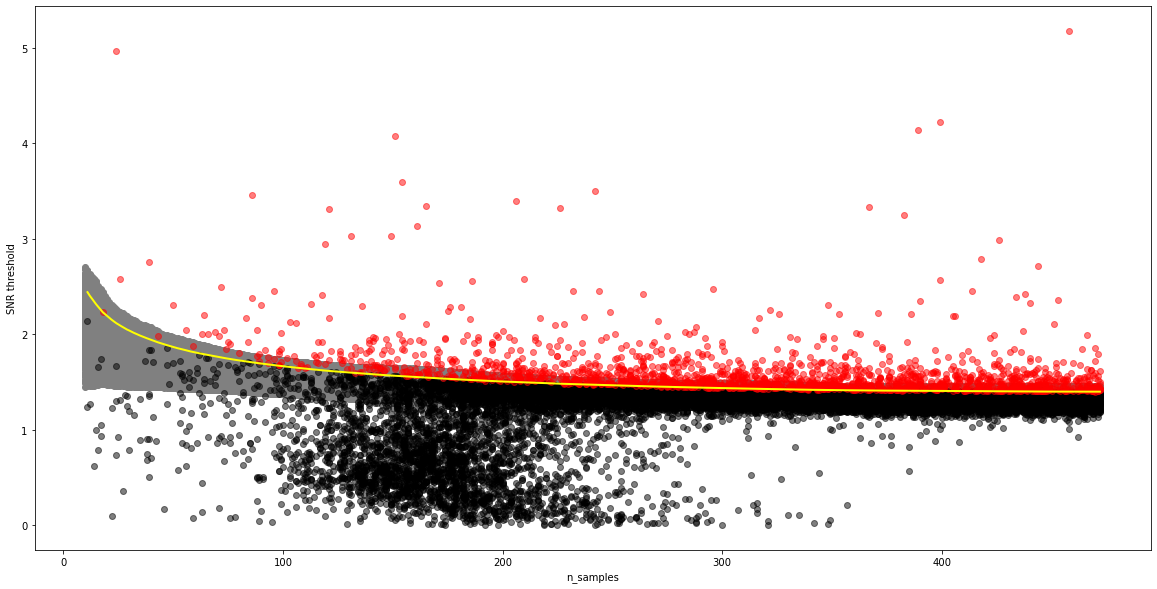

In [9]:
binarized_expressions2,stats2,empirical_snr2 = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples,pval=pval,
                                 plot_all = plot_all,show_fits = [],
                                 verbose= verbose,seed=87654321)



Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 945,
		number of samples in a bicluster: 10 - 472,
		n_permutations: 10000
snr_pval threshold: 0.01
			fraction: 0.03
	SNR thresholds for individual features computed in 7.23 seconds
	GMM method is chosen ...
		genes processed: 0
Gene ALG1L: SNR=1.6, pos=332, neg=0


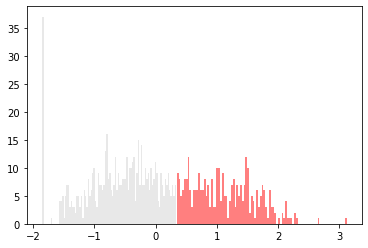

Gene APOBEC3A: SNR=1.42, pos=321, neg=0


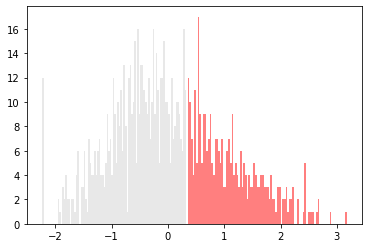

		genes processed: 1000
Gene BCL2L2: SNR=1.31, pos=0, neg=351


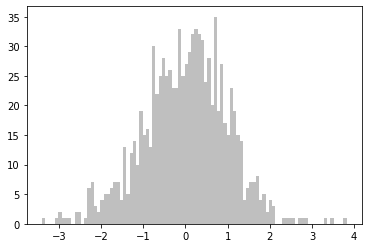

		genes processed: 2000
Gene CDK9: SNR=0.33, pos=232, neg=0


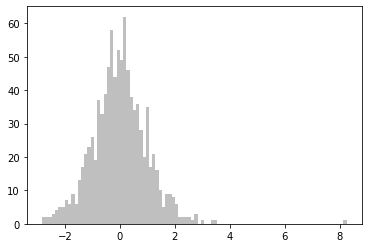

		genes processed: 3000
		genes processed: 4000
Gene ERBB2: SNR=2.3, pos=90, neg=0


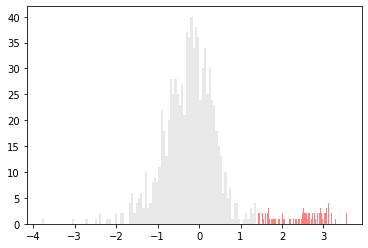

Gene ESR1: SNR=2.18, pos=0, neg=237


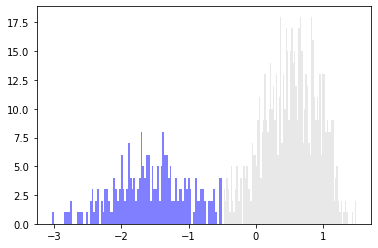

Gene FOXA1: SNR=2.24, pos=0, neg=175


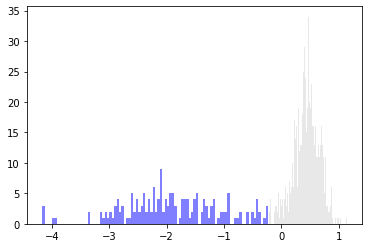

Gene GATA3: SNR=1.59, pos=0, neg=241


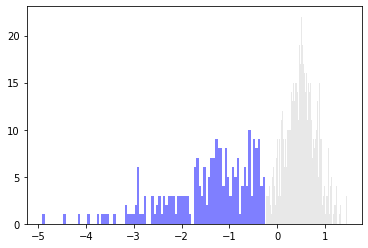

		genes processed: 5000
Gene GNGT1: SNR=1.71, pos=345, neg=0


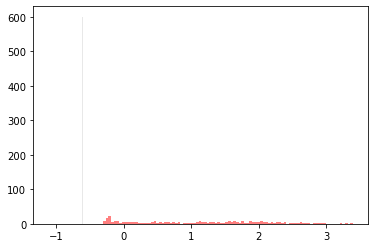

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
Gene PIK3R2: SNR=5.18, pos=0, neg=458


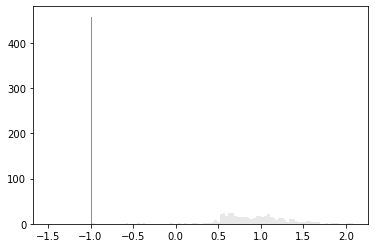

		genes processed: 10000
		genes processed: 11000
Gene SIRT6: SNR=1.43, pos=227, neg=0


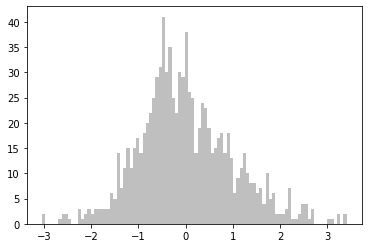

		genes processed: 12000
Gene SPOCK3: SNR=1.66, pos=0, neg=264


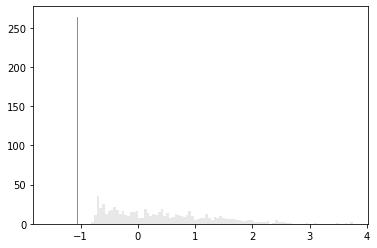

Gene STK31: SNR=1.67, pos=199, neg=0


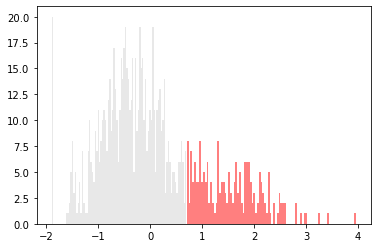

		genes processed: 13000
		genes processed: 14000
Gene ZNF415: SNR=1.61, pos=0, neg=123


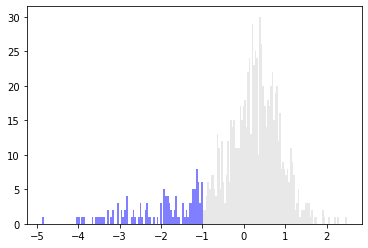

	GMM binarization for 14986 features completed in 169.47 s
	binarization runtime: 176.70 s
	1853 features passed binarization 
		UP-regulated features:	958
		DOWN-regulated features:	932
		ambiguous features:	37
Statistics is saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA_v2_975987923.GMM.binarization_stats.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA_v2_975987923.GMM.binarized_UP.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA_v2_975987923.GMM.binarized_DOWN.tsv


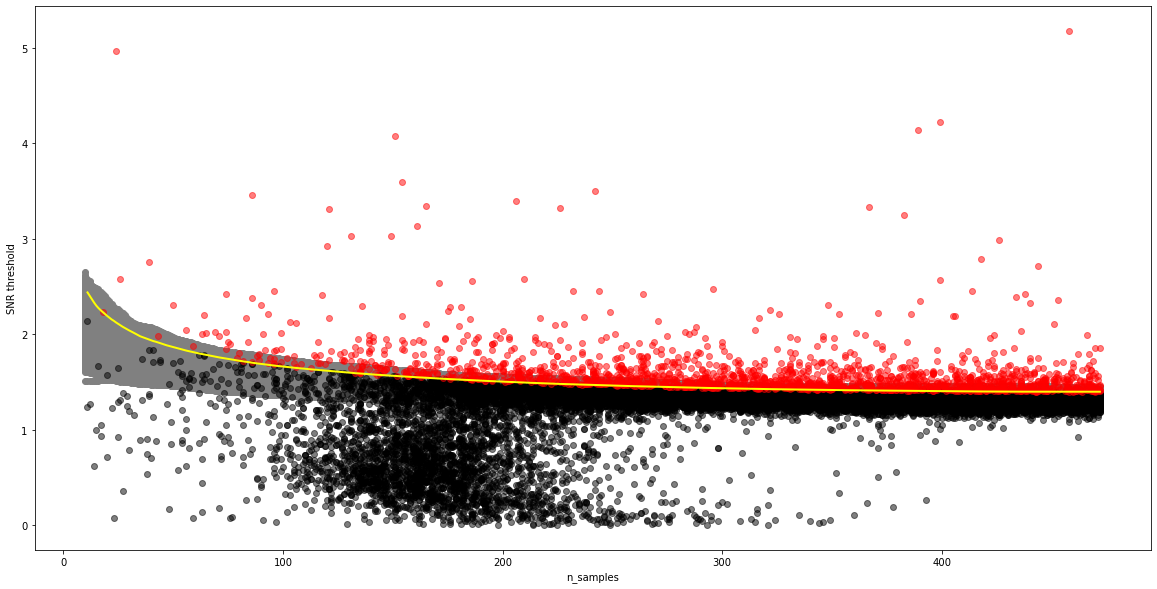

In [10]:
binarized_expressions,stats,empirical_snr = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples,pval=pval,
                                 plot_all = plot_all,show_fits = show_fits,
                                 verbose= verbose,seed=seed)
    

In [13]:
d = "DOWN"
s1 = set(binarized_expressions[d].columns)
s2 = set(binarized_expressions2[d].columns)
o  = s1.intersection(s2)
u  = s1.union(s2)
len(o)/len(u)

0.943796394485684

# Step 2. Group features into modules

Input: binarized inputs
Output: modules - sets of features with the same 1/0 profiles

 - feature clustering: choose WGCNA or DESMOND 
 - runs for up- and down-regulated features separately
 



###    WGCNA:

In [14]:
#basename = "METABRIC_"+str(seed) 
clust_method = "WGCNA"
if clust_method == "WGCNA":
    from method import run_WGCNA
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
        clustering_results[d] = run_WGCNA(fname, verbose = verbose)

Running WGCNA for /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA_v2_975987923.GMM.binarized_UP.tsv ...
	WGCNA runtime: modules detected in 9.86 s.
	65 modules and 552 not clustered genes
Running WGCNA for /home/olya/TUM/DESMOND/DESMOND2/tmp_results//TCGA-BRCA_v2_975987923.GMM.binarized_DOWN.tsv ...
	WGCNA runtime: modules detected in 9.36 s.
	32 modules and 276 not clustered genes


## Louvain

In [17]:
r = 0.33
J = 0.5
clust_method = "Louvain"
if clust_method == "Louvain":
    from method import run_Louvain, get_similarity_corr, get_similarity_jaccard
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        similarity = get_similarity_corr(binarized_expressions[d],r = r)
        clustering_results[d] = run_Louvain(similarity, verbose = True) 
        #similarity2 = get_similarity_jaccard(binarized_expressions[d],J=J,qval = 0.01)
        #clustering_results[d] = run_Louvain(similarity2, verbose = True) 
        

	 modules: 34 not_clustered: 276
		modularity: 0.361 runtime: 0.03 s
	 modules: 21 not_clustered: 240
		modularity: 0.193 runtime: 0.03 s


## Markov Clustering

In [25]:
#clust_method = "MCL"
if clust_method == "MCL":
    from method import run_MCL, get_similarity_corr
    r =0.33
    for d in ["UP","DOWN"]:
        print(d)
        similarity = get_similarity_corr(binarized_expressions[d],r = r)
        clustering_results[d] = run_MCL(similarity)#, inflations=inflations)

### DESMOND:

time:	Initial state created in 2.4 s.
		LP memory, 2.99 M
		step  1 16.6 s
		step  2 2.5 s
		step  3 1.5 s
		step  4 1.1 s
		step  5 0.8 s
		step  6 0.5 s
		step  7 0.6 s
		step  8 0.4 s
		step  9 0.7 s
		step  10 0.5 s
		step  11 0.7 s
			features oscilating in the last 10 steps: 74
		step  12 0.8 s
			features oscilating in the last 10 steps: 40
		step  13 0.5 s
			features oscilating in the last 10 steps: 30
		step  14 0.6 s
			features oscilating in the last 10 steps: 25
		step  15 0.6 s
			features oscilating in the last 10 steps: 23
		step  16 0.7 s
			features oscilating in the last 10 steps: 21
		step  17 0.6 s
			features oscilating in the last 10 steps: 19
		step  18 0.5 s
			features oscilating in the last 10 steps: 18
		step  19 0.8 s
			features oscilating in the last 10 steps: 16
		step  20 0.5 s
			features oscilating in the last 10 steps: 18
			convergence condition: True ; curve slope: -0.08
		step  21 0.7 s
			features oscilating in the last 10 steps: 14
			convergenc

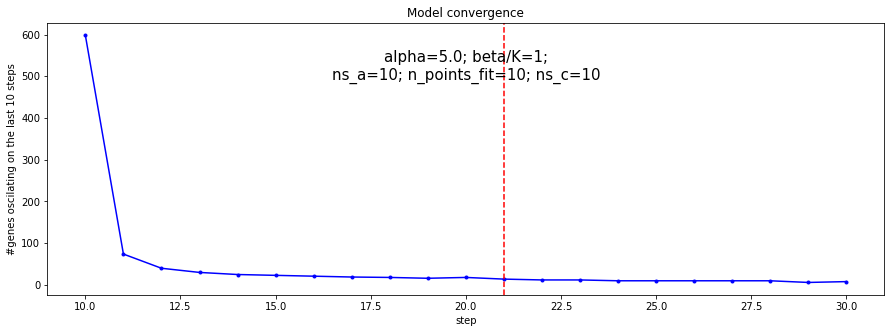

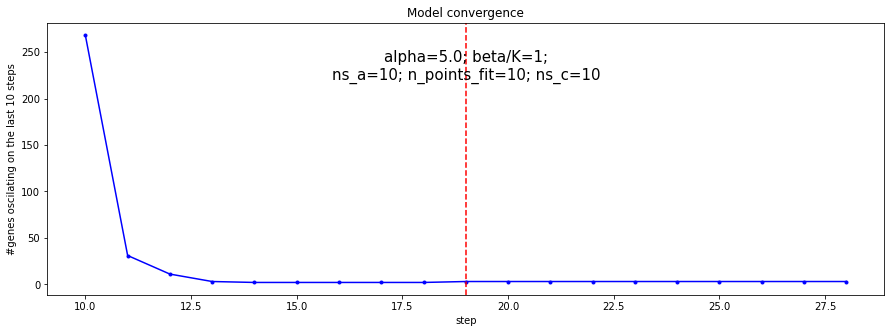

In [135]:
clust_method = "DESMOND"
if clust_method == "DESMOND":
    from pgm import run_sampling
    # PGM parameters
    alpha = 5.0 # convergence fails from 0.25; 0.33 is still Ok
    beta_K = 1

    # convergence
    max_n_steps= 50
    n_steps_averaged = 10
    n_points_fit=10
    n_steps_for_convergence = 10

    clustering_results ={}
    for d in ["UP","DOWN"]:
        exprs_bin = binarized_expressions[d]
        genes = exprs_bin.columns.values
        clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                    max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                    n_points_fit = n_points_fit, tol = 0.1,
                    n_steps_for_convergence = n_steps_for_convergence,
                    verbose =True,plot_all=plot_all)

# 3. K-means to split modules into biclusters and background

In [136]:
#from method import make_biclusters 
#from method import modules2biclusters, run_2means,add_SNR_to_biclusters



In [34]:
#basename = "METABRIC_975987923" + '_r'+str(round(r,2))
#basename

In [19]:
from method import make_biclusters 
biclusters = make_biclusters(clustering_results,binarized_expressions,exprs,
                                min_n_samples=min_n_samples, min_n_genes=2,
                                seed = seed,cluster_binary=True)

from method import write_bic_table
suffix  = ".bin="+bin_method+",clust="+clust_method
write_bic_table(biclusters, out_dir+basename+suffix+".biclusters.tsv",to_str=True,
                add_metadata=True, seed = seed, min_n_samples = min_n_samples, pval = pval,
                bin_method = bin_method, clust_method = clust_method, 
                alpha=alpha, beta_K = beta_K,r = r)
print(out_dir+basename+suffix+".biclusters.tsv")

biclusters.loc[biclusters["n_genes"]>0,:]

/home/olya/TUM/DESMOND/DESMOND2/method.py:72: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((sum_sq / count) - mean*mean)


(34, 9)
(21, 9)
/home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-BRCA_v2_975987923.bin=GMM,clust=Louvain.biclusters.tsv


,gene_ids,n_genes,sample_ids,n_samples,avgSNR,direction,genes,samples
0,"{385, 386}",2,"{513, 515, 520, 522, 17, 530, 534, 537, 542, 5...",136,1.962477,UP,"{HIST3H2A, HIST3H2BB}","{TCGA-AC-A4ZE-01, TCGA-AC-A3HN-01, TCGA-AC-A3E..."
1,"{676, 86}",2,"{2, 3, 5, 8, 11, 13, 14, 19, 21, 23, 25, 26, 2...",424,1.715437,UP,"{C21orf33, PWP2}","{TCGA-E2-A14Y-01, TCGA-A2-A4RX-01, TCGA-BH-A0H..."
2,"{833, 517, 104, 346, 629, 601, 250, 668}",8,"{1, 3, 525, 15, 528, 530, 535, 24, 25, 540, 37...",97,1.551011,UP,"{MIEN1, CASC3, GRB7, PSMD3, PGAP3, ERBB2, ORMD...","{TCGA-E2-A14Y-01, TCGA-B6-A1KN-01, TCGA-AR-A1A..."
3,"{509, 142}",2,"{0, 1, 2, 5, 6, 7, 13, 14, 16, 17, 19, 20, 21,...",402,1.441112,UP,"{CCNO, MCIDAS}","{TCGA-E2-A14Y-01, TCGA-A2-A0D2-01, TCGA-AN-A0A..."
4,"{66, 931, 495, 661, 54, 253}",6,"{5, 14, 530, 531, 532, 542, 544, 33, 546, 550,...",91,1.409309,UP,"{ASH2L, BAG4, WHSC1L1, ERLIN2, PROSC, LSM1}","{TCGA-B6-A1KN-01, TCGA-AC-A2BM-01, TCGA-A2-A0E..."
5,"{649, 179, 598}",3,"{0, 5, 517, 520, 525, 527, 17, 536, 26, 556, 4...",117,1.368725,UP,"{PPFIA1, ORAOV1, CTTN}","{TCGA-E2-A15K-01, TCGA-BH-A0HX-01, TCGA-AC-A4Z..."
6,"{716, 727}",2,"{4, 6, 7, 8, 12, 16, 17, 20, 22, 23, 25, 28, 3...",443,1.320383,UP,"{SAMD11, RP11-54O7.3}","{TCGA-E2-A14Y-01, TCGA-A2-A4RX-01, TCGA-A2-A0D..."
7,"{200, 592}",2,"{514, 6, 7, 9, 11, 523, 16, 529, 532, 533, 27,...",158,1.292516,UP,"{DDX43, OOEP}","{TCGA-BH-A1F6-01, TCGA-A2-A4RX-01, TCGA-E9-A24..."
8,"{624, 625}",2,"{0, 1, 2, 3, 515, 516, 517, 8, 526, 531, 532, ...",215,1.274673,UP,"{POTEF, POTEE}","{TCGA-BH-A1FL-01, TCGA-E2-A14Y-01, TCGA-E2-A1B..."
9,"{371, 372, 373, 374, 375, 376}",6,"{0, 1, 11, 12, 526, 15, 535, 26, 29, 31, 32, 5...",193,1.231945,UP,"{HOXB-AS3, HOXB8, HOXB4, HOXB5, HOXB9, HOXB6}","{TCGA-EW-A424-01, TCGA-GM-A2D9-01, TCGA-AR-A24..."


In [27]:
" ".join(sorted(biclusters.loc[4,"genes"]))

'CCNO MCIDAS'

In [28]:
show_genes = ["ERBB2","ESR1","FOXA1","GATA3","IFIT1","GZMB"]
for i in biclusters.index:
    gset = biclusters.loc[i,"genes"]
    o = gset.intersection(show_genes)
    if len(o)>0:
        print(len(o)," ".join(o))
        print(biclusters.loc[i,["n_genes","n_samples","avgSNR","direction"]])
        print(biclusters.loc[i,["genes"]])
        print()

1 ERBB2
n_genes             8
n_samples          97
avgSNR       1.551011
direction          UP
Name: 2, dtype: object
genes    {STARD3, GRB7, CASC3, PGAP3, ERBB2, ORMDL3, PS...
Name: 2, dtype: object

1 FOXA1
n_genes           161
n_samples         172
avgSNR       0.953367
direction          UP
Name: 21, dtype: object
genes    {VAV3, RANBP3L, SMIM14, CYP4X1, GHRH, TTC6, EP...
Name: 21, dtype: object

2 ESR1 GATA3
n_genes           163
n_samples         260
avgSNR       0.808167
direction          UP
Name: 32, dtype: object
genes    {TUBA3E, MS4A8, PDE6B, CACNG1, ZNF671, MAPT-IT...
Name: 32, dtype: object

2 IFIT1 GZMB
n_genes           28
n_samples        373
avgSNR       0.72015
direction         UP
Name: 37, dtype: object
genes    {KIR2DL4, LCNL1, ZNF80, IFNG, IDO2, IFIT1, MX1...
Name: 37, dtype: object



# All steps in one function

* Input:  expression matrix (genes x samples); z-normalized for between-sample comparison 
* Can start from binarized data if binarized = "binarized_data_file_prefix", e.g. 
  "path/to/results/TCGA" for files "TCGA.GMM.binarized_UP.tsv" and "TCGA.GMM.binarized_DOWN.tsv" 
  and bin_mehtod="GMM"
* Output: 
     - biclusters: {"UP":df_biclusters_up, "DOWN":df_biclusters_down}
     - biclusters are also save to files
     - lists of not clustered genes:   {"UP":df_biclusters_up, "DOWN":df_biclusters_down}

In [36]:
def run_DESMOND(exprs_file, basename, out_dir="",  
                binarized_data = None, save=True, load = False,
                bin_method = "GMM", clust_method = "Louvain", cluster_binary=False, 
                min_n_samples = -1, show_fits = [],
                pval = 0.001,
                r = 1/3, # Louvain - cutoff for similarity matrix
                alpha=1,beta_K = 1, # DESMOND
                max_n_steps= 50, n_steps_for_convergence = 10,
                seed = 42,
                verbose = True, plot_all = False):
    
    start_time = time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 
        
    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)
    if verbose:
        print("Read input from:",exprs_file ,file=sys.stdout)
        print("\t{} features x {} samples".format(exprs.shape[0],exprs.shape[1]) ,file=sys.stdout)

    #check if expressions are standardized (mean=0, std =1)
    if not validate_input_matrix(exprs):
        print("Centering mean to 0 and std to 1",file= sys.stderr)
        m = exprs.mean(axis=1)
        std = exprs.std(axis=1)
        exprs = exprs.T-m
        exprs = exprs.T
        exprs = exprs.T/std
        exprs = exprs.T

    # define minimal number of samples
    if min_n_samples == -1:
        min_n_samples = round(min(0.5*exprs.shape[1],max(10,0.01*exprs.shape[1])))
    if verbose:
        print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
    if min_n_samples < 10:
        print("min_n_samples is recommended to be >= 10", file= sys.stderr)    
    
    ######### binarization #########
    from method import binarize
    binarized_expressions,stats,empirical_snr = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples,pval=pval,
                                 plot_all = plot_all,show_fits = show_fits,
                                 verbose= verbose,seed=seed)
    
    ######### gene clustering #########
    if clust_method == "Louvain":
        from method import run_Louvain, get_similarity_corr

        clustering_results = {}
        for d in ["UP","DOWN"]:
            similarity = get_similarity_corr(binarized_expressions[d],r = r)
            clustering_results[d] = run_Louvain(similarity, verbose = True) 

    elif clust_method == "WGCNA":
        from method import run_WGCNA

        clustering_results = {}
        for d in ["UP","DOWN"]:
            fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
            clustering_results[d] = run_WGCNA(fname, verbose = verbose)
            
    elif clust_method == "DESMOND":
        from pgm import run_sampling
        
        # convergence
        n_steps_averaged = 10
        n_points_fit=10

        clustering_results ={}
        for d in ["UP","DOWN"]:
            exprs_bin = binarized_expressions[d]
            genes = exprs_bin.columns.values
            clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                        max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                        n_points_fit = n_points_fit, tol = 0.1,
                        n_steps_for_convergence = n_steps_for_convergence,
                        verbose =verbose,plot_all=plot_all)
    else:
        print("'clust_method' must be 'WGCNA' or 'DESMOND'.",file=sys.stderr)
        
    ######### making biclusters #########
    from method import make_biclusters 
    biclusters = make_biclusters(clustering_results,binarized_expressions,exprs,
                                min_n_samples=min_n_samples, min_n_genes=2,
                                seed = seed,cluster_binary=cluster_binary)

    from method import write_bic_table
    suffix  = ".bin="+bin_method+",clust="+clust_method
    write_bic_table(biclusters, out_dir+basename+suffix+".biclusters.tsv",to_str=True,
                    add_metadata=True, seed = seed, min_n_samples = min_n_samples, pval = pval,
                    bin_method = bin_method, clust_method = clust_method, 
                    alpha=alpha, beta_K = beta_K,r = r)

    print(out_dir+basename+suffix+".biclusters.tsv")
    
    print("Total runtime: {:.2f} s".format(time()-start_time ),file = sys.stdout)
    
    return biclusters

# Running DESMOND with various parameters 

In [37]:
random.seed(seed)
seeds = [random.randint(0,1000000) for i in range(5)]
seeds

[416123, 171446, 284042, 564788, 39674]

In [ ]:
data_dir = "/home/olya/TUM/DESMOND/datasets_14K/"
exprs_file = data_dir + "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv"#"OV_norm_counts.log2.z.tsv"

out_dir = os.getcwd()+"/tmp_results/"

for i in range(0,5):
    print("run:",i,"seed:",seeds[i])
    for  p in [0.001,0.005,0.01]:
        basename = "TCGA-BRCA_p"+str(p)+".run_"+str(i)
        for m in ["GMM","Jenks"]:
            biclusters = run_DESMOND(exprs_file,basename,seed=seeds[i], out_dir=out_dir,
                                     pval = p, bin_method = m,
                                     clust_method = "WGCNA", plot_all=False,
                                     cluster_binary=True)
            biclusters = run_DESMOND(exprs_file,basename,seed=seeds[i], out_dir=out_dir,
                                     pval = p, bin_method = m,
                                     clust_method = "Louvain", r=1/3, plot_all=False,
                                     cluster_binary=True)

run: 0 seed: 416123
Read input from: /home/olya/TUM/DESMOND/datasets_14K/TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv
	14986 features x 945 samples
Mininal number of samples in a bicluster: 10

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 945,
		number of samples in a bicluster: 10 - 472,
		n_permutations: 10000
snr_pval threshold: 0.001
			fraction: 0.03
	SNR thresholds for individual features computed in 8.94 seconds
	GMM method is chosen ...
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
	GMM binarization for 14986 features completed in 147.14 s
	binarization runtime: 156.09 s
	1362 features pas

# METABRIC

In [ ]:
data_dir = "/home/olya/TUM/DESMOND/datasets_14K/"
exprs_file = data_dir + "METABRIC_1904_14K.nolog2_exprs_z.tsv"

out_dir = os.getcwd()+"/tmp_results/"

for i in range(0,5):
    print("run:",i,"seed:",seeds[i])
    for  p in [0.001,0.005,0.01]:
        basename = "METABRIC_p"+str(p)+".run_"+str(i)
        for m in ["GMM","Jenks"]:
            biclusters = run_DESMOND(exprs_file,basename,seed=seeds[i], out_dir=out_dir,
                                     pval = p, bin_method = m,
                                     clust_method = "Louvain", r=1/3, plot_all=False,
                                     cluster_binary=True)

            biclusters = run_DESMOND(exprs_file,basename,seed=seeds[i], out_dir=out_dir,
                                     pval = p, bin_method = m,
                                     clust_method = "WGCNA", plot_all=False,
                                     cluster_binary=True)

# Find best matches

In [ ]:
from method import read_bic_table

In [24]:
results_file_name  = "tmp_results/TCGA-BRCA_945.run_0.bin=GMM,clust=Louvain.biclusters.tsv"
b, m = read_bic_table(results_file_name, parse_metadata = True)
print(m)
b

#seed=126789; pval=0.001; min_n_samples=10; b=GMM; c=Louvain; r=0.3333333333333333; 

{'seed': '126789', 'pval': '0.001', 'min_n_samples': '10', 'b': 'GMM', 'c': 'Louvain', 'r': '0.3333333333333333;'}


,avgSNR,n_genes,n_samples,direction,genes,samples,gene_ids,sample_ids
id,,,,,,,,
0,1.761490,2,406,UP,"{C21orf33, PWP2}","{TCGA-OL-A5D6-01, TCGA-D8-A27F-01, TCGA-C8-A12...","{515, 63}","{2, 3, 5, 8, 11, 13, 14, 19, 21, 23, 25, 26, 2..."
1,1.555283,2,129,UP,"{OOEP, DDX43}","{TCGA-A2-A0CX-01, TCGA-XX-A89A-01, TCGA-A1-A0S...","{451, 148}","{514, 6, 523, 16, 529, 27, 28, 29, 541, 31, 54..."
2,1.543319,2,206,DOWN,"{HIST3H2BB, HIST3H2A}","{TCGA-B6-A0WT-01, TCGA-C8-A12T-01, TCGA-A8-A09...","{292, 293}","{513, 515, 6, 8, 520, 522, 523, 13, 525, 16, 1..."
3,1.494141,2,377,DOWN,"{CCNO, MCIDAS}","{TCGA-AR-A0TY-01, TCGA-D8-A27F-01, TCGA-E9-A3Q...","{395, 116}","{0, 1, 5, 6, 7, 13, 14, 16, 17, 19, 20, 21, 22..."
4,1.441826,8,109,UP,"{MIEN1, GRB7, PSMD3, ORMDL3, PGAP3, CASC3, STA...","{TCGA-GM-A2DA-01, TCGA-C8-A1HK-01, TCGA-C8-A12...","{482, 263, 74, 394, 460, 508, 626, 188}","{1, 3, 525, 15, 528, 530, 535, 24, 25, 540, 37..."
5,1.370912,2,448,UP,"{RP11-54O7.3, SAMD11}","{TCGA-OL-A5D6-01, TCGA-AR-A0TY-01, TCGA-BH-A0D...","{548, 541}","{0, 1, 2, 3, 9, 10, 11, 13, 14, 15, 18, 21, 24..."
6,1.346786,3,137,UP,"{PPFIA1, ORAOV1, CTTN}","{TCGA-AO-A126-01, TCGA-C8-A1HK-01, TCGA-XX-A89...","{496, 457, 132}","{0, 5, 517, 520, 525, 527, 17, 532, 26, 556, 4..."
7,1.341904,2,210,UP,"{ALG1L, GNGT1}","{TCGA-GM-A2DA-01, TCGA-A2-A0YI-01, TCGA-AC-A8O...","{16, 253}","{1, 514, 518, 519, 9, 13, 525, 529, 535, 24, 5..."
8,1.319622,5,116,UP,"{ASH2L, LSM1, PROSC, WHSC1L1, BAG4}","{TCGA-BH-A1EO-01, TCGA-E9-A1R2-01, TCGA-B6-A0W...","{39, 377, 49, 502, 697}","{2, 5, 14, 528, 530, 531, 532, 542, 544, 33, 5..."


In [56]:
results_file_name  = "tmp_results/TCGA-BRCA_945.run_0.bin=GMM,clust=Louvain.biclusters.tsv"
bics1 = read_bic_table(results_file_name, parse_metadata = False)
bics1.shape

(42, 8)

In [57]:
bics1
#" ".join(sorted(bics1.loc[15,"genes"]))

,avgSNR,n_genes,n_samples,direction,genes,samples,gene_ids,sample_ids
id,,,,,,,,
0,1.761490,2,406,UP,"{C21orf33, PWP2}","{TCGA-OL-A5D6-01, TCGA-D8-A27F-01, TCGA-C8-A12...","{515, 63}","{2, 3, 5, 8, 11, 13, 14, 19, 21, 23, 25, 26, 2..."
1,1.555283,2,129,UP,"{OOEP, DDX43}","{TCGA-A2-A0CX-01, TCGA-XX-A89A-01, TCGA-A1-A0S...","{451, 148}","{514, 6, 523, 16, 529, 27, 28, 29, 541, 31, 54..."
2,1.543319,2,206,DOWN,"{HIST3H2BB, HIST3H2A}","{TCGA-B6-A0WT-01, TCGA-C8-A12T-01, TCGA-A8-A09...","{292, 293}","{513, 515, 6, 8, 520, 522, 523, 13, 525, 16, 1..."
3,1.494141,2,377,DOWN,"{CCNO, MCIDAS}","{TCGA-AR-A0TY-01, TCGA-D8-A27F-01, TCGA-E9-A3Q...","{395, 116}","{0, 1, 5, 6, 7, 13, 14, 16, 17, 19, 20, 21, 22..."
4,1.441826,8,109,UP,"{MIEN1, GRB7, PSMD3, ORMDL3, PGAP3, CASC3, STA...","{TCGA-GM-A2DA-01, TCGA-C8-A1HK-01, TCGA-C8-A12...","{482, 263, 74, 394, 460, 508, 626, 188}","{1, 3, 525, 15, 528, 530, 535, 24, 25, 540, 37..."
5,1.370912,2,448,UP,"{RP11-54O7.3, SAMD11}","{TCGA-OL-A5D6-01, TCGA-AR-A0TY-01, TCGA-BH-A0D...","{548, 541}","{0, 1, 2, 3, 9, 10, 11, 13, 14, 15, 18, 21, 24..."
6,1.346786,3,137,UP,"{PPFIA1, ORAOV1, CTTN}","{TCGA-AO-A126-01, TCGA-C8-A1HK-01, TCGA-XX-A89...","{496, 457, 132}","{0, 5, 517, 520, 525, 527, 17, 532, 26, 556, 4..."
7,1.341904,2,210,UP,"{ALG1L, GNGT1}","{TCGA-GM-A2DA-01, TCGA-A2-A0YI-01, TCGA-AC-A8O...","{16, 253}","{1, 514, 518, 519, 9, 13, 525, 529, 535, 24, 5..."
8,1.319622,5,116,UP,"{ASH2L, LSM1, PROSC, WHSC1L1, BAG4}","{TCGA-BH-A1EO-01, TCGA-E9-A1R2-01, TCGA-B6-A0W...","{39, 377, 49, 502, 697}","{2, 5, 14, 528, 530, 531, 532, 542, 544, 33, 5..."


In [23]:
results_file_name  = "tmp_results/METABRIC_1904_v2_975987923.bin=GMM,clust=WGCNA.biclusters.tsv"
bics2 = read_bic_table(results_file_name, parse_metadata = False)
print(bics2.shape)

results_file_name  = "tmp_results/METABRIC_1904_975987923.bin=GMM,clust=WGCNA.biclusters.tsv"
bics1 = read_bic_table(results_file_name, parse_metadata = False)
bics1.shape

(53, 8)


(53, 8)

In [24]:
for r1 in bics1.iterrows():
    bic1 = r1[1]
    g1 = bic1["genes"]
    bm = []
    best_J = 0
    best_o  = []
    for r2 in bics2.iterrows():
        bic2 = r2[1]
        g2 = bic2["genes"]
        o = g1.intersection(g2)
        J = len(o)/len(g1.union(g2))
        if J > best_J:
            best_J = J
            best_o = o
            bm = bic2
    if len(bm)>0 and len(best_o)>1 and best_J>0:
        print(round(best_J,2)," ".join(sorted(best_o)))
        print("\t",round(bic1["avgSNR"],2)," ".join(sorted(g1)))
        print("\t",round(bm["avgSNR"],2)," ".join(sorted(bm["genes"])))
        print("\n")

1.0 SCGB1D2 SCGB2A2
	 1.78 SCGB1D2 SCGB2A2
	 1.78 SCGB1D2 SCGB2A2


1.0 GSTM1 GSTM2
	 1.68 GSTM1 GSTM2
	 1.68 GSTM1 GSTM2


1.0 ADH1A CIDEC
	 1.49 ADH1A CIDEC
	 1.49 ADH1A CIDEC


1.0 STEAP1 STEAP1B
	 1.4 STEAP1 STEAP1B
	 1.4 STEAP1 STEAP1B


1.0 EGR1 FOS
	 1.38 EGR1 FOS
	 1.38 EGR1 FOS


1.0 IGKC JCHAIN
	 1.38 IGKC JCHAIN
	 1.38 IGKC JCHAIN


0.9 ERBB2 GRB7 GSDMB MBD4 MIEN1 ORMDL3 PGAP3 PSMD3 SAMD11
	 1.32 ERBB2 GRB7 GSDMB MBD4 MIEN1 ORMDL3 PGAP3 PSMD3 SAMD11 STARD3
	 1.28 ERBB2 GRB7 GSDMB MBD4 MIEN1 ORMDL3 PGAP3 PSMD3 SAMD11


1.0 ANKRD30A AREG C9orf152 CAMK2N1 CAPN13 CMBL CYB5A DEGS2 EEF1A2 FBP1 FOXA1 KIAA1324 LRRC26 MLPH MUC1 REEP1 REEP6 SLC44A4 SMIM14 SPDEF TFF1 TFF3 XBP1 ZG16B
	 1.31 ANKRD30A AREG C9orf152 CAMK2N1 CAPN13 CMBL CYB5A DEGS2 EEF1A2 FBP1 FOXA1 KIAA1324 LRRC26 MLPH MUC1 REEP1 REEP6 SLC44A4 SMIM14 SPDEF TFF1 TFF3 XBP1 ZG16B
	 1.31 ANKRD30A AREG C9orf152 CAMK2N1 CAPN13 CMBL CYB5A DEGS2 EEF1A2 FBP1 FOXA1 KIAA1324 LRRC26 MLPH MUC1 REEP1 REEP6 SLC44A4 SMIM14 SPDEF TFF1 TFF3

8